# Further exploration

One thing I've realized recently is that my focus on Europe is a bit short-sighted.  Instead, it would be useful to see where we do get propagation from, on what bands, and at what times during the day.  To that end, I'd like to see if I can get some initial graphs for:

- DX totals, defined as "non-US/non-Canada"
- distance

Let's start with the standard imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# FIXME: Figure out difference between "notebook" and "inline"
%matplotlib notebook

There's a new `Makefile` target that creates `data/interim/ve7cc_dx.csv`.  Also, I've downloaded skimmer records from 2018 as well as 2019, so we'll have MOAR DATA to work with.

In [2]:
from src.data.load_dataset import load_dataset

data_file = '../data/interim/ve7cc_dx.csv'
data = load_dataset(data_file)

Let's start by getting some info about where signals are coming from.

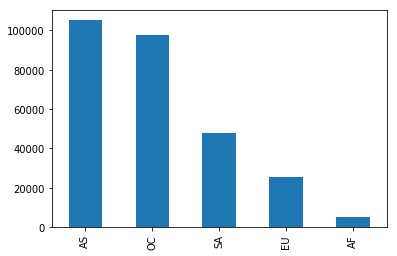

In [3]:
data.dx_cont.value_counts().plot(kind='bar')

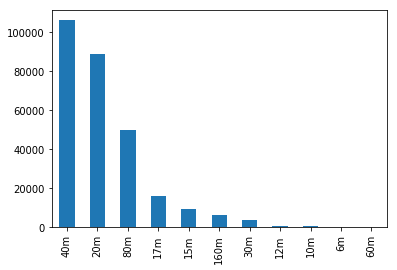

In [4]:
data.band.value_counts().plot(kind='bar')

Okay, let's see if we can get a feel for when we see DX on 40m.

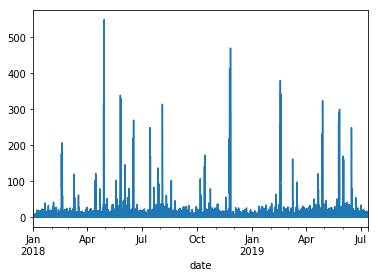

In [5]:
from src.data.utils import count_by_hour

hourly_40m = count_by_hour(data, '40m')
hourly_40m.total.plot()

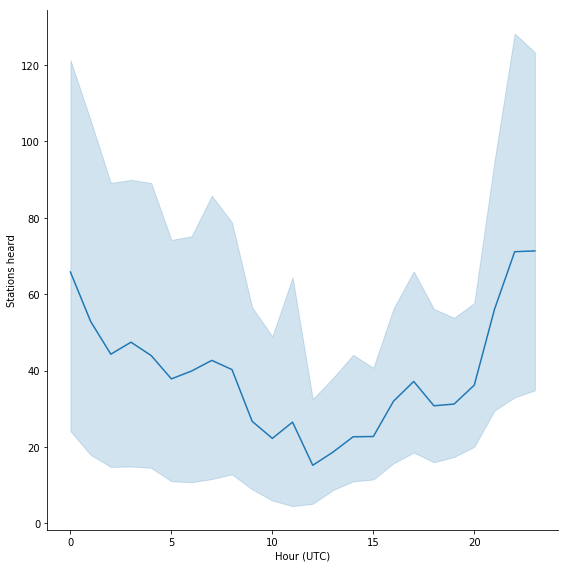

In [6]:
from src.data.utils import group_by_hour, graph_by_hour

graph_by_hour(data[data.band == '20m'])

There are a couple things I'd like to do here:

- Use the `dx_continent` column to build a set of individual continent features (`NA`, `EU`, etc), to help with model building.
- Calculate sunrise or sun angle, and use that as a feature.
  - Should be okay to have sun_angle, or hours_since_sunrise, as a float or int; it does progress, so that should be okay.
- It would also be interesting to see DX as a fraction of total, which would mean loading a different data set.

Let's start on the first one: building a set of individual continent features.

In [7]:
data.dtypes
dx_continents = ['AS', 'OC', 'SA', 'EU', 'AF']
for cont in dx_continents:
    col_name = 'dx_{}'.format(cont)
    data[col_name] = 0
    # For my own reference, this is how this next line works:
    # - data.loc lets you access rows and columns
    # - you can set conditions -- so in this case, that 'dx_cont' column == continent
    # - you can specify a column to return, rather than the whole row - so in this case, col_name
    # - and then you can assign to those returned columns
    # - profit!
    # Ref: https://stackoverflow.com/questions/49161120/pandas-python-set-value-of-one-column-based-on-value-in-another-column
    data.loc[data['dx_cont'] == cont, col_name] = 1

In [18]:
hourly_20m = count_by_hour(data, '20m')

I need to think about this a bit more.

My questions are:

- given band, time of day, time of year, ...
  - how many dx stations from each continent should i expect to hear in that hour?
  
This sounds an awful lot like making a vector prediction:

```
X = { band = '20m', hour = '14', time_of_year = '183', hrs_past_sunset = '8', ... }
y = { dx_AS = '1', dx_EU = '4', .... }
```

Alternately, you could imagine:

```
X = { hour = '14', ... }
y = { band_20m = '4', band_30m = '9', ... }
```

[This link](https://towardsdatascience.com/regression-models-with-multiple-target-variables-8baa75aacd) may be helpful.

I'm not sure if this can be done or not.  If not, an alternative is to make the model specific to each band-continet tuple.  Another simple way to get started would just be to predict total dx, and figure out breakdown by continent later.

Hokay!  Given all that...running the `group_by_hour` function up above loses the continent info, but we can do okay without it.

In [19]:
from src.data.utils import add_time_columns

add_time_columns(hourly_20m)
hourly_20m.head()

total  hour  month  annual  weekend  arrl_dx_contest
date                                                                     
2018-01-01 00:00:00     17     0      1     0.0      0.0              0.0
2018-01-01 01:00:00     13     1      1     0.0      0.0              0.0
2018-01-01 02:00:00      1     2      1     0.0      0.0              0.0
2018-01-01 03:00:00      0     3      1     0.0      0.0              0.0
2018-01-01 04:00:00      0     4      1     0.0      0.0              0.0

# Next

Add hours since sunrise, or angle above horizon, or something.

- Add https://astral.readthedocs.io/en/stable/index.html to requirements.txt

In [10]:
import datetime
import pytz # may be needed for time zone conversions ahead
from astral import Astral

city_name = 'Vancouver'
a = Astral()
a.solar_depression = 'civil'
city = a[city_name]
print(city.timezone)

print('Latitude: %.02f, Longitude: %.02f' % (city.latitude, city.longitude))
sun = city.sun(date=datetime.date(2019,11,21), local=True)
# print('Sunrise today: %s' % str(sun['golden_hour']))
print(city.solar_elevation(dateandtime=datetime.datetime(2019, 11, 21, 7)))

America/Vancouver
Latitude: 49.25, Longitude: -123.10
-5.510672819256655


In [12]:
# Let's take the index of the last entry...
a = hourly_20m[:1].index
print(a)

# ...convert it to datetime...
b = a.to_pydatetime()
print(b[0])

# ...and see if we can get the solar elevation at that time.
print(city.solar_elevation(dateandtime=b[0]))
#a['solar_elevation'] = city.solar_elevation(dateandtime=a.index.to_pydatetime())

DatetimeIndex(['2018-01-01'], dtype='datetime64[ns]', name='date', freq='H')
2018-01-01 00:00:00
-63.52165069265064


Hurrah, that works!

Can we build that up for the whole dataframe?

In [13]:
# %%timeit 
#
# for i, d in hourly_20m.iterrows():
#    hourly_20m.at[i, 'solar_elevation'] = city.solar_elevation(dateandtime=i.to_pydatetime())

# Time was 2.53 s ± 462 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# Note

The `df.iterrows()` approach up above is not good:

- ["Don't iterate!"](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas/55557758#55557758)
- ["Don't modify while iterating"](https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row/29262040#29262040)

I've taken this approach for now because it appears that I'm running into this problem:

- An individual item from the index can be turned into a solar elevation; the `solar_elevation` function takes it and converts it just fine.
- However, *multiple values from the index* -- whether a slice or the whole index -- come as an `np.ndarray` instance, and `solar_function` throws an error:

In [14]:
hourly_20m['solar_elevation'] = city.solar_elevation(dateandtime=hourly_20m.index.to_pydatetime())

AttributeError: 'numpy.ndarray' object has no attribute 'tzinfo'

Given that, I'm not sure how to do this without iterating over everything.  [This article](https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6) is worth reading.

...Wait a minute, I think I might have this...

In [20]:
hourly_20m['solar_elevation'] = hourly_20m.index.to_series().apply(lambda x: city.solar_elevation(x))
# Time ends up being 4.63 s ± 377 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [17]:
hourly_20m.head()

total  hour  month  annual  weekend  arrl_dx_contest  \
date                                                                        
2018-01-01 00:00:00     17     0      1     0.0      0.0              0.0   
2018-01-01 01:00:00     13     1      1     0.0      0.0              0.0   
2018-01-01 02:00:00      1     2      1     0.0      0.0              0.0   
2018-01-01 03:00:00      0     3      1     0.0      0.0              0.0   
2018-01-01 04:00:00      0     4      1     0.0      0.0              0.0   

                     solar_elevation  
date                                  
2018-01-01 00:00:00       -63.521651  
2018-01-01 01:00:00       -62.314340  
2018-01-01 02:00:00       -56.693450  
2018-01-01 03:00:00       -48.519541  
2018-01-01 04:00:00       -39.175510

Okay, looks like this should be fairly simple!